#1. alpha와 beta
- 개별 주식이나 포트폴리오의 위험을 나타내는 상대적인 지표
- 시장 리스크 등 기준이 되는 지표와의 상대적 변동성의 비율
- CAPM(자본자산가격결정모형)에서 개별자산과 포트폴리오의 위험을 측정

 - Alpha: 주식 투자의 초과 수익률, 기대 수익률과 기준 지수의 예상 수익률 간 차이. alpha>0: 시장 평균보다 초과 수익
 - Beta: 주식 또는 포트폴리오의 변동성이 시장 변동성과 연관 정도 측정. beta가 1에 가까우면 시장과의 상관관계가 높고, 1보다 작으면 시장보다 변동성이 낮으며, 1보다 크면 시장보다 변동성이 높음

In [20]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [21]:
risky_asset = 'AMZN'
market_benchmark = '^GSPC'  #S&P500
start_date = '2022-01-01'
end_date = '2023-12-31'

In [22]:
df = yf.download( [risky_asset, market_benchmark], start=start_date, end = end_date, progress=False)

/tmp/ipython-input-22-66951337.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download( [risky_asset, market_benchmark], start=start_date, end = end_date, progress=False)


In [23]:
X = df['Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}).resample('M').last().pct_change().dropna()
X

/tmp/ipython-input-23-4166839863.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = df['Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}).resample('M').last().pct_change().dropna()


Ticker,asset,market
Date,,
2022-02-28,0.026673,-0.031360
2022-03-31,0.061437,0.035773
2022-04-30,-0.237525,-0.087957
2022-05-31,-0.032764,0.000053
2022-06-30,-0.116459,-0.083920
2022-07-31,0.270596,0.091116
2022-08-31,-0.060615,-0.042440
2022-09-30,-0.108622,-0.093396
2022-10-31,-0.093451,0.079863


In [24]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X['market'].var()
beta = covariance / benchmark_variance
beta

np.float64(1.4487845995278597)

In [25]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X[['market']], X['asset'])
model.coef_[0]

np.float64(1.4487845995278594)

#2. 포트폴리오
* 포트폴리오 최적화: 투자자 목표 수익율과 위험 선호도에 따라 가장 적합한 자산 배분 탐색

* 포트폴리오란? 투자자가 보유한 주식과 채권 등 여러 투자자산으로 이루어진 그룹

* 현대 포트폴리오 이론(Modern Portfolio Theory)
 - 해리 마코위츠, 상관관계가 낮은 여러 자산을 섞어서 분산투자
 - 동일한 수익율에서 위험을 낮출 수 있음
 - 위험은 낮추고 기대 수익율은 높은 포트폴리오 추구
 - High Risk High Return을 극복
 - 위험 대비 기대수익율이 높은 조합을 발견
 - 분산 투자의 중요성

* 포트폴리오의 체계적, 비체계적 위험
 - 시장위험 = 체계적 위험
 - 개별 자산 위험 = 비체계적 위험
 - 잘 분산된 PF는 비체계적 위험이 0에 가깝게 설정하여 최소화

* 라이브러리: PyPortfolioOpt

In [26]:
!pip install PyPortfolioOpt

In [27]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '^KQ11': 'KOSDAQ',
    '348210.KQ': '넥스틴',
    '058610.KQ': '에스피지',
    '114840.KQ': '아이패밀리에스씨',
    '007660.KS': '이수페타시스',
    '272210.KS': '한화시스템',
    '093320.KQ': '케이아이엔엑스',
    '003230.KS': '삼양식품',
    '024110.KS': '기업은행',
    '347890.KQ': '엠투아이',
    '119610.KQ': '인터로조',
    '215000.KQ': '골프존',
    '336260.KS': '두산퓨얼셀',
    '005300.KS': '롯데칠성',
    '281740.KQ': '레이크머티리얼즈',
    '253450.KQ': '스튜디오드래곤',
    '213420.KQ': '덕산네오룩스',
    '006890.KS': '태경케미컬',
    '060720.KQ': 'KH바텍',
    '190510.KQ': '나무가',
    '002310.KS': '아세아제지',
    '013310.KQ': '아진산업',
    '003720.KS': '삼영',
    '025320.KQ': '시노펙스',
    '383310.KQ': '에코프로에이치엔',
    '145720.KS': '덴티움',
    '337930.KQ': '브랜드엑스코퍼레이션',
    '393890.KQ': '더블유씨피',
    '074600.KQ': '원익QnC',
    '251970.KQ': '펌텍코리아',
    '166090.KQ': '하나머티리얼즈',
    '036890.KQ': '진성티이씨',
    '089850.KQ': '유비벨록스',
    '403870.KQ': 'HPSP',
    '104540.KQ': '코렌텍',
    '047810.KS': '한국항공우주',
    '183300.KQ': '코미코',
    '298050.KS': '효성첨단소재',
    '214150.KQ': '클래시스',
    '086670.KQ': '비엠티',
    '078350.KQ': '한양디지텍',
    '307950.KS': '현대오토에버',
    '332370.KQ': '아이디피',
    '192820.KS': '코스맥스',
    '259960.KS': '크래프톤',
}
tickers = list(ticker_names.keys())

In [28]:
df = yf.download(tickers)
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

/tmp/ipython-input-28-1445602210.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers)
[*********************100%***********************]  46 of 46 completed


#3. 자본자산 가격결정(CAPM: Capital Asset Pricing Model)
 - 개별 종목의 기대수익율: 시장 전체 수익율의 흐름에 영향
 - 위험 자산 기대 수익율 = 무위험자산 수익율 + b X Risk Premium
 - Risk Premium: 시장 수익율 = 무위험자산 수익율
 - beta: 위험자산 민감도, 특정 자산의 체계적 위험 측정 지표
 - beta = 시장 수익율과 위험자산 수익율의 공분산 /  위험자산 수익율의 분산
 - ols로 추정
 - 개별 종목 기대수익율은 개별 종목 위험에 비례
 - 베타: 개별 종목의 기대수익율 추정

In [29]:
!unzip malgun.zip

Archive:  malgun.zip
  inflating: malgun.ttf              


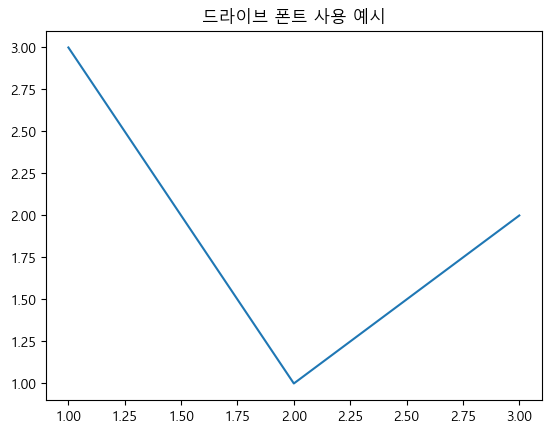

In [64]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

fm.fontManager.addfont("malgun.ttf")
plt.rcParams["font.family"] = "malgun"  # addfont 후 이름 인식됨
plt.rcParams["axes.unicode_minus"] = False

plt.plot([1,2,3], [3,1,2])
plt.title("드라이브 폰트 사용 예시")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '현대건설'),
  Text(1, 0, 'DB하이텍'),
  Text(2, 0, '에스엘'),
  Text(3, 0, '동원산업'),
  Text(4, 0, 'DN오토모티브'),
  Text(5, 0, '서연'),
  Text(6, 0, '경인전자'),
  Text(7, 0, '현대코퍼레이션'),
  Text(8, 0, '계룡건설'),
  Text(9, 0, '퍼시스'),
  Text(10, 0, '코웨이'),
  Text(11, 0, '동원F&B'),
  Text(12, 0, '풍산'),
  Text(13, 0, 'LX세미콘'),
  Text(14, 0, '동인기연'),
  Text(15, 0, '한국타이어앤테크놀로지'),
  Text(16, 0, '더블유게임즈'),
  Text(17, 0, '서연이화'),
  Text(18, 0, 'HD현대건설기계'),
  Text(19, 0, 'DL이앤씨'),
  Text(20, 0, 'KOSPI')])

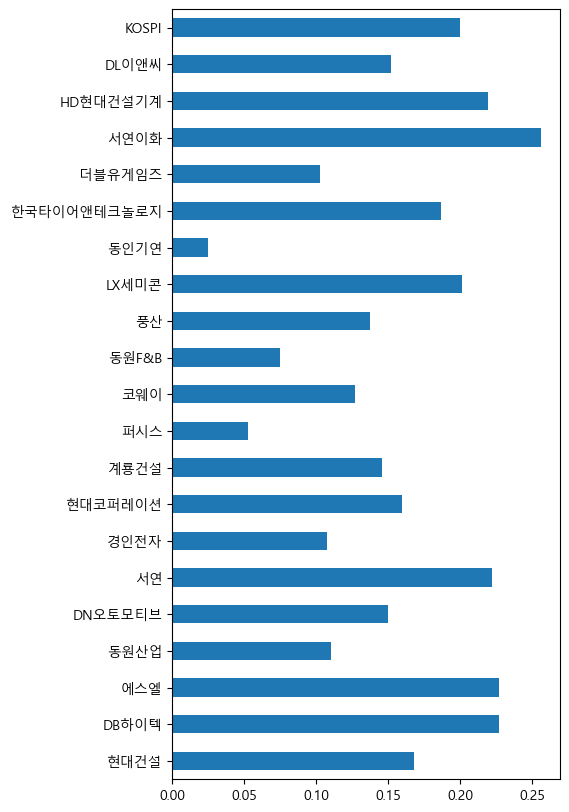

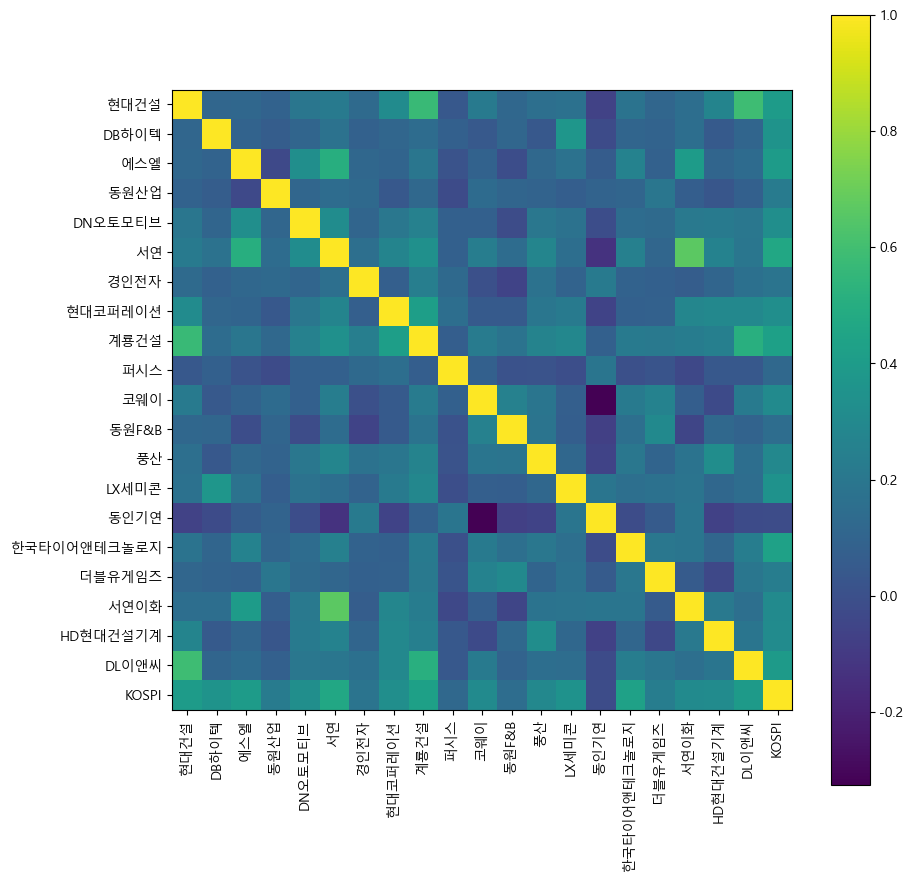

In [65]:
from pypfopt import expected_returns

risk_free_rate= 0.035	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices, market_prices=prices['KOSPI'].to_frame(), risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices, frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

#4. Efficient Frontier
- 투자 대상 중 가장 적절한 수익율과 위험을 가진 종목을 이은 곡선
- 효율적 포트폴리오: 주어진 위험 수준 대비 가장 높은 수익률을 제공하는 포트폴리오
- MPT에서의 위험: 수익률의 변동성( 과거 수익률의 표준편차)
- 동일한 기대 수익률 내에서 가장 작은 위험을 가진 포트폴리오의 집합
- 개별 종목의 기대수익률은 개별 종목의 위험에 비례하며 커지며, 특히 기대수익률 대비 위험이 큰 종목도 있고 낮은 종목도 있음
- 효율적 프론티어란 동일한 위험에서 가장 높은 수익률을 기대할 수 있는 종목들을 선으로 이은 것


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49340 (\N{HA

Expected annual return: 87.0%
Annual volatility: 17.5%
Sharpe Ratio: 4.76


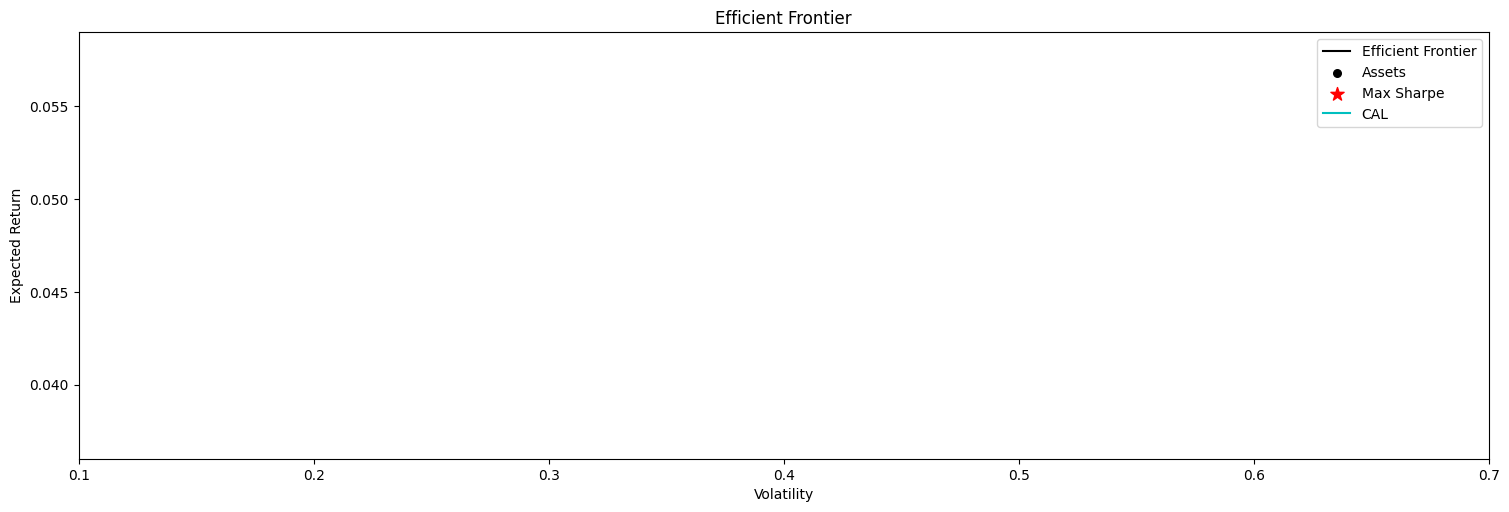

In [32]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.1) # 개별종목 비중 10% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0.1, 0.7)
ax.set_ylim(0.036, 0.059)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()



 - 포트폴리오에서는 단일 종목의 비중이 너무 크지 않도록 제한: 예, 10%
 - 효율적 프론티어 우측: 코스피 지수, 코스닥은 코스피보다 위험은 크고 기대 수익률은 낮음

/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt

<Axes: xlabel='Weight'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missin

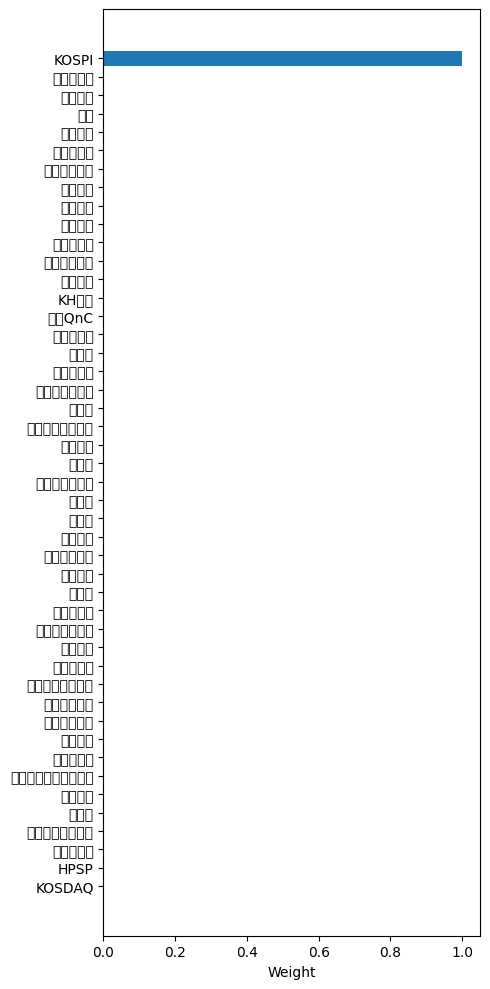

In [33]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

- 포트폴리오 자산 배분: 코스피를 98% 이상 포함
- CAL: 효율적 프론티어 곡선에 접하는 직선,자본배분선
- MPT에서 도출된 위험자산만으로 구성된 효율적 포트폴리오에 무위험자산을 포함, 낮은 위험과 높은 기대수익률의 포트폴리오 집합, 이를 자본배분선으로 지칭

- 자본배분선의 y 절편: 무위험자산을 100% 보유하는 포트폴리오, 기대 수익률은 무위험수익률과 동일
- 자본배분선과 효율적 프론티어 곡선이 접하는 지점: 위험자산만을 보유했을 때 가장 효율적인 포트폴리오
 - 자본배분선과 효율적 프론티어 곡선이 접하는 지점이 샤프 비율이 최대가 되는 포트폴리오

- 샤프 비율(Sharpe Ratio): 해리 마코위츠의 제자 윌리엄 샤프가 개발한 투자 성과 판단용 지표
 - 총위험(total risk)에 집중하는 위험 대 보상 비율(Reward-to-risk Ratio)

    Sharpe = (Rp-Rf) / Sigmap

 - 높은 샤프 비율을 기록하는 투자일수록 더 적은 위험으로 더 높은 수익률을 내고자 함
 - 샤프 비율이 0 이하라면 시장수익률보다 낮은 수익률 의미: 샤프 비율이 0 이상이어야 투자의 고려 대상, 1 이상이면 상당히 괜찮은 투자처

#5. 효율적 시장 가설(EMH; Efficient Market Hypothesis)
- 효율적 시장 가설: 가격은 상품에 대해 얻을 수 있는 모든 정보를 빠르게 반영, 투자자는 장기적으로 시장 수익률을 넘을 수 없음

- 예를 들어, 개별주와 시장 지수(Market Index)를 포함하는 포트폴리오를 최적화, 코스피가 효율적 프론티어 위에 위치하며, 포트폴리오에 코스피를 98% 이상 배분 하라는 결과

- 해석: 코스피 100%를 보유하는 것도 매우 효율적인 포트폴리오일 수 있고, 2%의 개별주를 넣으라는 것은 오히려 단기적인 오차로 인한 결과로 의심

- 한국의 주식 시장은 효율적 시장 가설을 잘 따라가는 것으로 고려, 코스피가 효율적인 포트폴리오

#6. 포트폴리오 실습

In [34]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '272210.KS': '한화시스템',
    '079550.KS': 'LIG넥스원',
    '012450.KS': '한화에어로스페이스',
    '329180.KS': 'HD현대중공업',
    '042660.KS': '한화오션',
    '064350.KS': '현대로템',
    '103140.KS': '풍산',
    '047810.KS': '한국항공우주',
    '039130.KS': '하나투어',
    '004170.KS': '신세계',
    '008770.KS': '호텔신라',
    '023530.KS': '롯데쇼핑',
    '069960.KS': '현대백화점',
    '005930.KS': '삼성전자',
    '017670.KS': 'SK텔레콤',
    '030200.KS': 'KT',
    '000660.KS': 'SK하이닉스',
}
tickers = list(ticker_names.keys())

In [35]:
df = yf.download(tickers, start="2020-01-01", end="2023-12-31")
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

/tmp/ipython-input-35-79979127.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  18 of 18 completed


In [36]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'SK하이닉스'),
  Text(1, 0, '신세계'),
  Text(2, 0, '삼성전자'),
  Text(3, 0, '호텔신라'),
  Text(4, 0, '한화에어로스페이스'),
  Text(5, 0, 'SK텔레콤'),
  Text(6, 0, '롯데쇼핑'),
  Text(7, 0, 'KT'),
  Text(8, 0, '하나투어'),
  Text(9, 0, '한화오션'),
  Text(10, 0, '한국항공우주'),
  Text(11, 0, '현대로템'),
  Text(12, 0, '현대백화점'),
  Text(13, 0, 'LIG넥스원'),
  Text(14, 0, '풍산'),
  Text(15, 0, '한화시스템'),
  Text(16, 0, 'HD현대중공업'),
  Text(17, 0, 'KOSPI')])

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missin

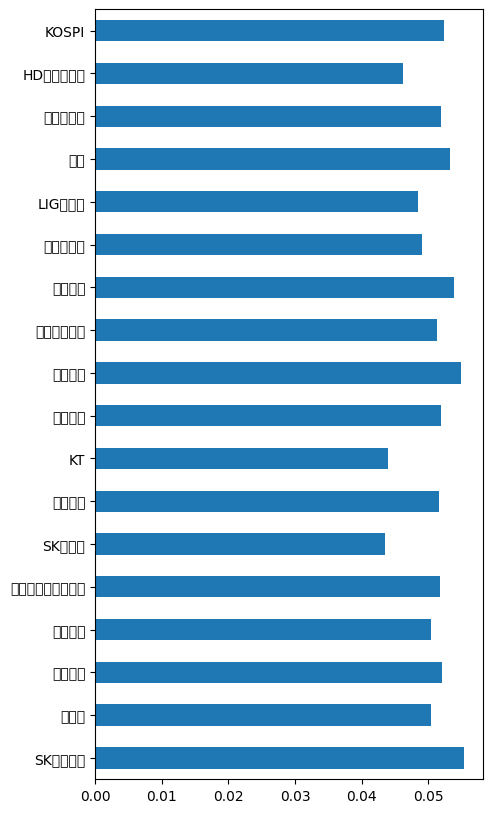

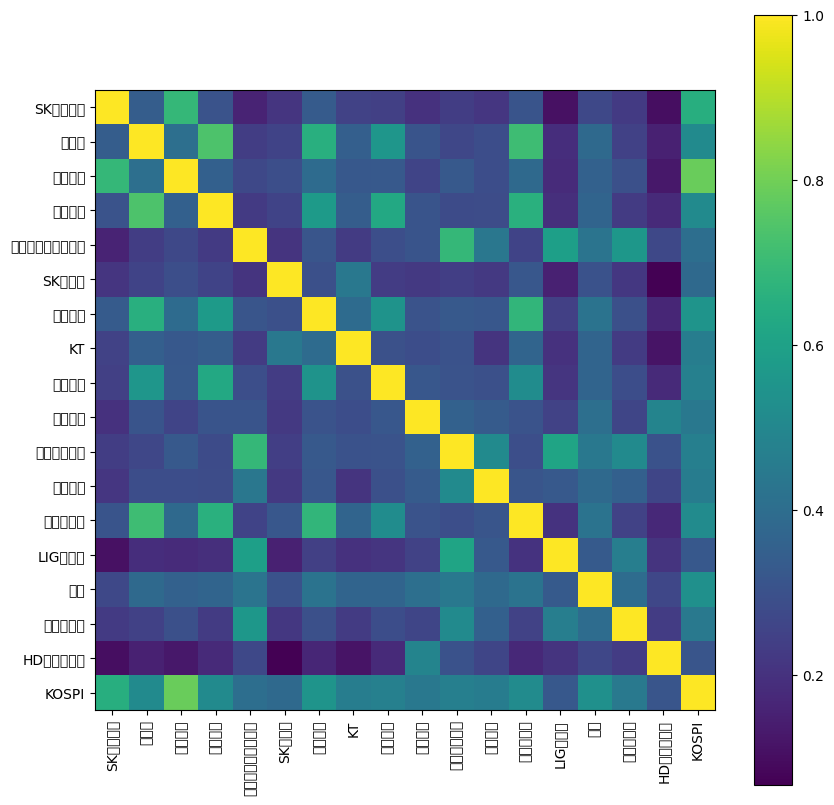

In [37]:
from pypfopt import expected_returns

risk_free_rate= 0.035	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices, market_prices=prices['KOSPI'].to_frame(), risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices, frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt

Expected annual return: 5.2%
Annual volatility: 20.4%
Sharpe Ratio: 0.09


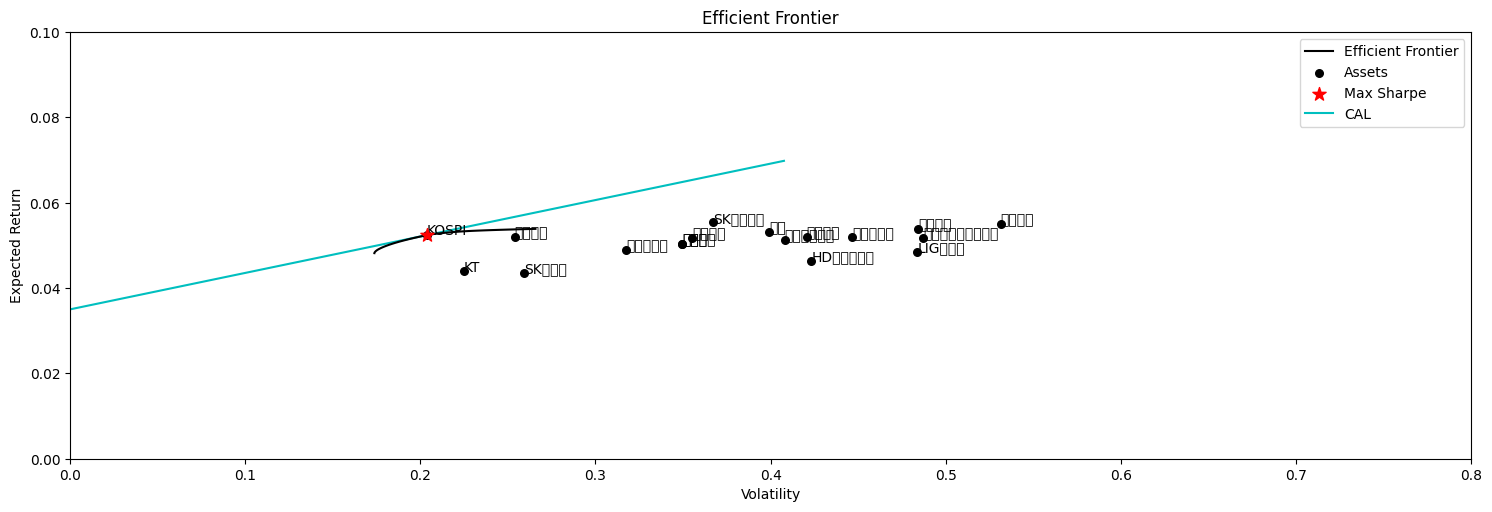

In [38]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.2) # 개별종목 비중 20% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.1)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()



/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt

<Axes: xlabel='Weight'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missin

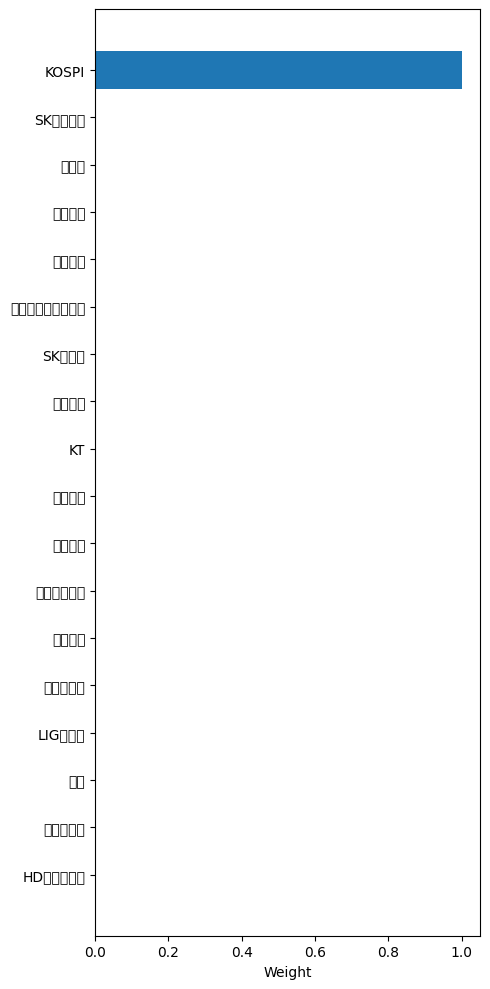

In [39]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

#7. 군집 분석
- pykrx로 20241219의 종목에 대한 market fundamental 데이터를 수집하여서 군집 분석하세요.
- 군집 중 투자할만한 군집을 발견/해석해보세요.
- 해당 군집 중 EPS 기준 상위 20개 종목을 발견해보세요.

In [40]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 18.5 MB/s eta 0:00:00


In [41]:
from pykrx import stock
df = stock.get_market_fundamental("20241218")

In [42]:
from sklearn.cluster import KMeans

#scaling
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
scaler = MinMaxScaler()
df_scaled = pd.DataFrame( scaler.fit_transform(df),
                          columns=df.columns,
                           index=df.index)

cl1 = KMeans().fit( df_scaled  )
pd.DataFrame( cl1.cluster_centers_, columns=df.columns)

,BPS,PER,PBR,EPS,DIV,DPS
0,0.005765,0.000450,0.017722,0.019076,0.126799,0.016686
1,0.084415,0.000262,0.015652,0.603505,0.192131,0.217300
2,0.003509,0.001955,0.040914,0.009567,0.011341,0.003229
3,0.003491,0.006062,0.401255,0.037953,0.011312,0.013703
4,0.007038,0.000854,0.015148,0.022976,0.246247,0.034985
5,0.057939,0.000536,0.031216,0.178025,0.134700,0.102451
6,0.068834,0.000815,0.045826,0.336306,0.233316,0.613367
7,0.008712,0.019057,0.019811,0.037423,0.398710,0.089179


In [43]:
df["cluster"] = cl1.labels_
print( df.cluster.value_counts() )
cl1.inertia_

cluster
2    365
0    224
4    182
5     63
7     54
3     19
1     16
6      6
Name: count, dtype: int64


9.531720337715383

In [44]:
df_top20 = df.query("cluster==0").nlargest(20, "EPS")

In [45]:
df_top20

,BPS,PER,PBR,EPS,DIV,DPS,cluster
티커,,,,,,,
267270,86604,8.10,0.72,7659,1.13,700,0
192080,44663,6.92,1.18,7635,1.89,1000,0
016800,59291,5.58,0.70,7470,2.88,1200,0
005850,41872,4.41,0.77,7285,2.80,900,0
011760,48070,2.84,0.41,6968,3.03,600,0
021240,36380,10.87,1.94,6495,1.91,1350,0
007340,26478,2.99,0.72,6386,3.15,600,0
000990,41655,5.57,0.83,6241,1.67,580,0
006040,74866,6.38,0.53,6237,2.76,1100,0


In [46]:
ticker_name = []

for i in df_top20.index:
  ticker_name.append( stock.get_market_ticker_name(i) )

df_top20["name"] = ticker_name
df_top20["ticker"] = df_top20.index
df_top20

,BPS,PER,PBR,EPS,DIV,DPS,cluster,name,ticker
티커,,,,,,,,,
267270,86604,8.10,0.72,7659,1.13,700,0,HD현대건설기계,267270
192080,44663,6.92,1.18,7635,1.89,1000,0,더블유게임즈,192080
016800,59291,5.58,0.70,7470,2.88,1200,0,퍼시스,016800
005850,41872,4.41,0.77,7285,2.80,900,0,에스엘,005850
011760,48070,2.84,0.41,6968,3.03,600,0,현대코퍼레이션,011760
021240,36380,10.87,1.94,6495,1.91,1350,0,코웨이,021240
007340,26478,2.99,0.72,6386,3.15,600,0,DN오토모티브,007340
000990,41655,5.57,0.83,6241,1.67,580,0,DB하이텍,000990
006040,74866,6.38,0.53,6237,2.76,1100,0,동원산업,006040


#8. 포트폴리오 구성
- 앞에서 선택한 군집의 종목 20개들로 포트폴리오를 구성해보세요.
- 주가는 2023년에 대해 다운로드 하며, yahoo finance를 사용하세요
- risk free rate은 0.03을 사용해보세요
- 포트폴리오에서 모든 종목 비중을 최대 10%로 지정하세요 (kospi도 적용)


In [47]:
tmp = df_top20.ticker.to_list()
tickers = [i+ ".KS" for i in tmp ]
tickers.append( '^KS11')

In [48]:
names = df_top20.name.to_list()
names.append('KOSPI')

In [49]:
ticker_name = dict(zip(tickers, names))
print(ticker_name)


{'267270.KS': 'HD현대건설기계', '192080.KS': '더블유게임즈', '016800.KS': '퍼시스', '005850.KS': '에스엘', '011760.KS': '현대코퍼레이션', '021240.KS': '코웨이', '007340.KS': 'DN오토모티브', '000990.KS': 'DB하이텍', '006040.KS': '동원산업', '108320.KS': 'LX세미콘', '161390.KS': '한국타이어앤테크놀로지', '200880.KS': '서연이화', '103140.KS': '풍산', '049770.KS': '동원F&B', '013580.KS': '계룡건설', '007860.KS': '서연', '000720.KS': '현대건설', '375500.KS': 'DL이앤씨', '009140.KS': '경인전자', '111380.KS': '동인기연', '^KS11': 'KOSPI'}


In [51]:
import yfinance as yf
df = yf.download(tickers, start="2023-01-01", end="2023-12-31")
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_name, inplace=True)


/tmp/ipython-input-51-2257459433.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  21 of 21 completed


In [52]:
!pip install PyPortfolioOpt

In [53]:
prices

Ticker,현대건설,DB하이텍,에스엘,동원산업,DN오토모티브,서연,경인전자,현대코퍼레이션,계룡건설,퍼시스,...,동원F&B,풍산,LX세미콘,동인기연,한국타이어앤테크놀로지,더블유게임즈,서연이화,HD현대건설기계,DL이앤씨,KOSPI
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,32429.695312,35249.363281,22269.423828,45156.031250,11775.803711,6818.879395,22722.662109,14528.380859,16411.384766,27746.773438,...,29723.259766,30536.031250,65814.156250,NaN,28670.619141,36881.699219,7786.590820,59235.347656,31279.269531,2225.669922
2023-01-03,33057.054688,36116.148438,22269.423828,46446.207031,11850.928711,6742.690918,22529.277344,14388.235352,16222.747070,27746.773438,...,29532.726562,29748.304688,66379.890625,NaN,28670.619141,36284.261719,7680.057617,59747.761719,31521.746094,2218.679932
2023-01-04,34649.585938,38331.273438,21894.361328,45893.273438,12095.083984,6676.025391,22964.390625,14715.240234,16600.019531,27840.353516,...,29437.458984,29238.597656,71471.531250,NaN,28716.863281,36563.062500,7680.057617,60157.695312,32831.109375,2255.979980
2023-01-05,34456.550781,37994.191406,21753.710938,45616.812500,11813.366211,6571.266113,23544.542969,14902.100586,17118.769531,27840.353516,...,29151.658203,29006.914062,68642.843750,NaN,28485.648438,36602.894531,7496.046387,57185.679688,32831.109375,2264.649902
2023-01-06,36290.375000,40450.085938,23253.966797,44188.406250,11719.458984,6685.548828,23641.236328,14948.816406,17543.203125,27840.353516,...,28865.857422,29609.292969,69208.578125,NaN,29040.562500,35925.800781,7844.699707,57493.132812,34964.886719,2289.969971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,33587.898438,56822.742188,33568.226562,28796.648438,13351.336914,7961.708496,20837.164062,17929.236328,13402.629883,30788.156250,...,30533.027344,36142.800781,81937.679688,19768.990234,41294.941406,39112.125000,17238.968750,53496.277344,35595.324219,2600.020020
2023-12-22,33539.640625,57207.980469,33286.929688,28668.091797,13691.256836,7818.854492,20837.164062,17761.062500,13742.175781,30507.412109,...,30580.660156,35818.437500,84200.632812,20995.705078,41294.941406,38873.152344,17626.361328,52573.933594,35595.324219,2599.510010
2023-12-26,33732.675781,57689.531250,33240.046875,28625.238281,13540.180664,7714.095215,20837.164062,17779.746094,13940.244141,29758.763672,...,31533.330078,36235.472656,84577.789062,20618.255859,41942.343750,39231.613281,17471.404297,53393.796875,35498.332031,2602.590088


In [54]:
#!unzip malgun.zip

In [62]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

<Axes: >

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) m

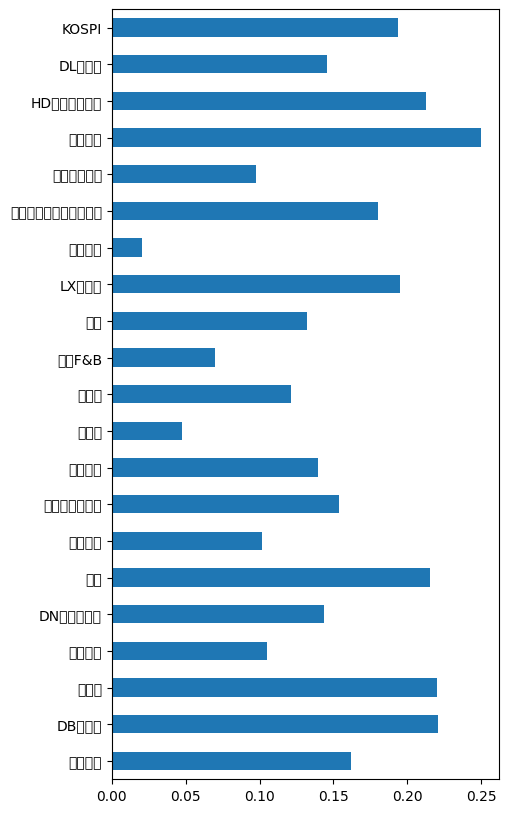

In [63]:
from pypfopt import expected_returns

risk_free_rate= 0.03	#한국무위험지표금리의 1년 평균 사용, https://www.kofr.kr/main.jsp
mu = expected_returns.capm_return(prices, market_prices=prices['KOSPI'].to_frame(),
                                  risk_free_rate=risk_free_rate,
                                  frequency=245)	#1년 지정
mu.plot.barh(figsize=(5, 10))

In [57]:
#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices, frequency=245)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '현대건설'),
  Text(1, 0, 'DB하이텍'),
  Text(2, 0, '에스엘'),
  Text(3, 0, '동원산업'),
  Text(4, 0, 'DN오토모티브'),
  Text(5, 0, '서연'),
  Text(6, 0, '경인전자'),
  Text(7, 0, '현대코퍼레이션'),
  Text(8, 0, '계룡건설'),
  Text(9, 0, '퍼시스'),
  Text(10, 0, '코웨이'),
  Text(11, 0, '동원F&B'),
  Text(12, 0, '풍산'),
  Text(13, 0, 'LX세미콘'),
  Text(14, 0, '동인기연'),
  Text(15, 0, '한국타이어앤테크놀로지'),
  Text(16, 0, '더블유게임즈'),
  Text(17, 0, '서연이화'),
  Text(18, 0, 'HD현대건설기계'),
  Text(19, 0, 'DL이앤씨'),
  Text(20, 0, 'KOSPI')])

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) m

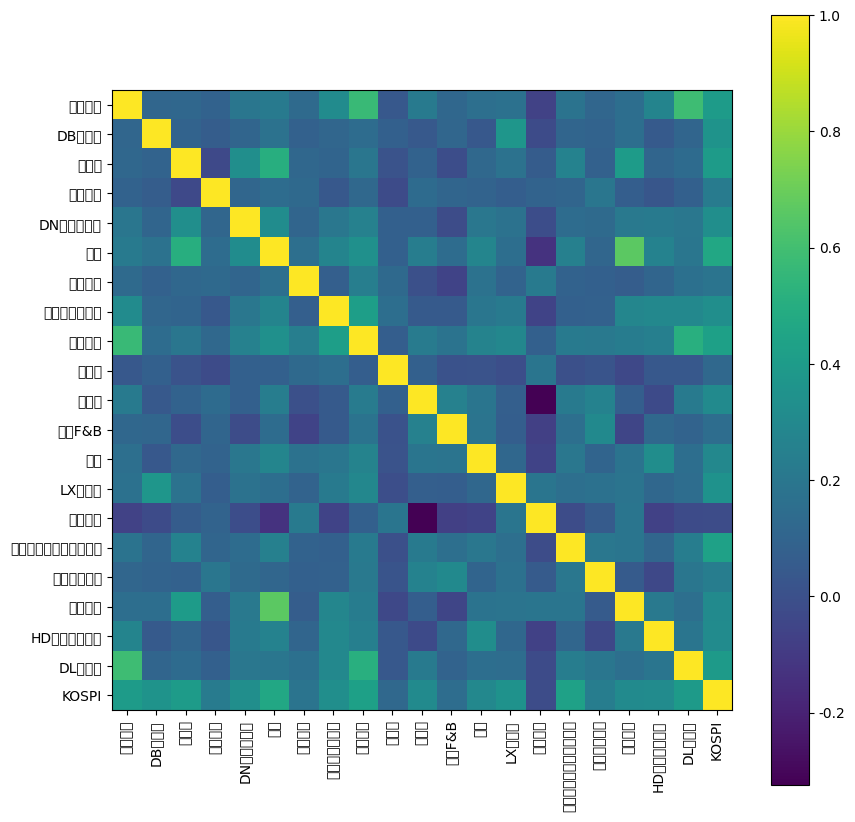

In [58]:
# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.


Expected annual return: 15.5%
Annual volatility: 14.6%
Sharpe Ratio: 0.86


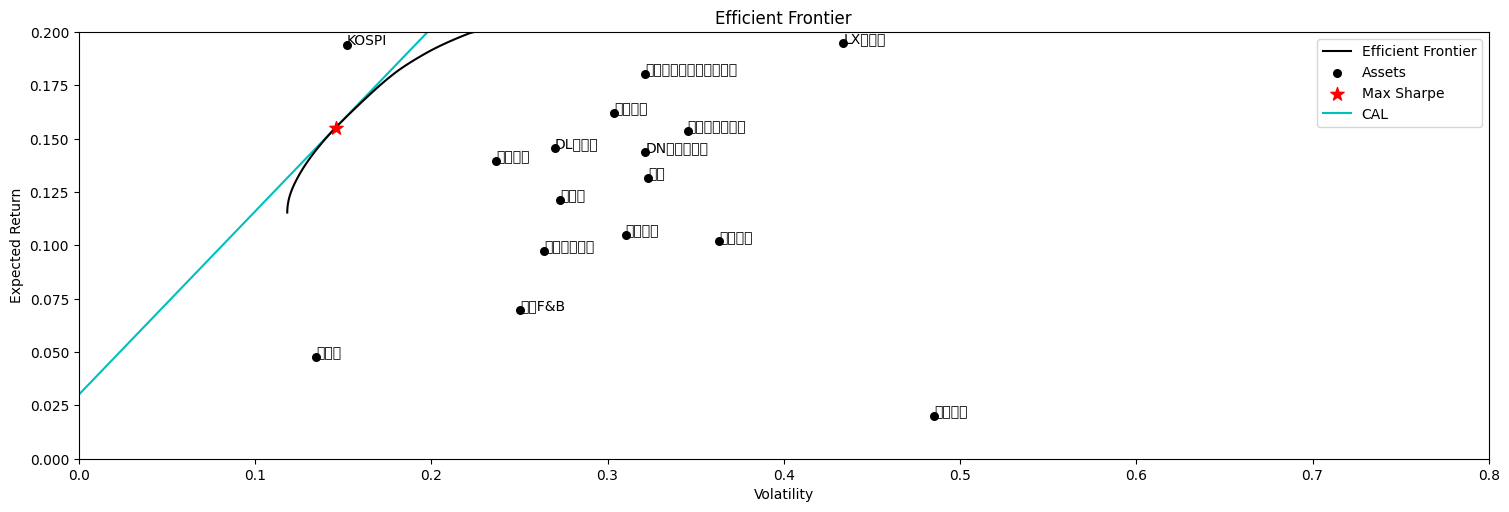

In [59]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_name.values()):
    #if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.1) # 개별종목 비중 10% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")
# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)
# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0, 0.8)  #범위 지정
ax.set_ylim(0, 0.2)  #범위 지정
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()

/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/pypfopt/plotting.py:53: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  p

<Axes: xlabel='Weight'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) miss

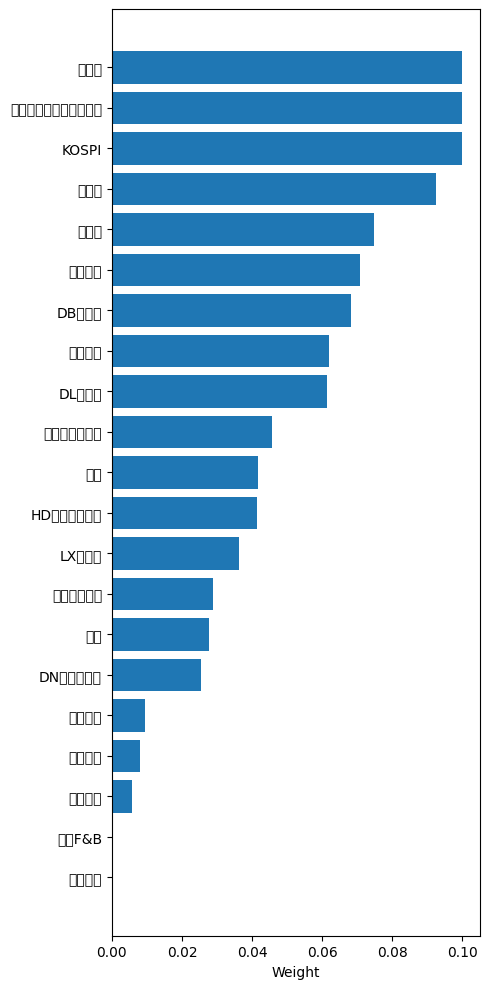

In [60]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

In [61]:
weights

OrderedDict([('현대건설', 0.06188),
             ('DB하이텍', 0.06808),
             ('에스엘', 0.07472),
             ('동원산업', 0.07071),
             ('DN오토모티브', 0.02554),
             ('서연', 0.04176),
             ('경인전자', 0.00804),
             ('현대코퍼레이션', 0.0458),
             ('계룡건설', 0.00583),
             ('퍼시스', 0.1),
             ('코웨이', 0.09257),
             ('동원F&B', 0.0),
             ('풍산', 0.02762),
             ('LX세미콘', 0.03627),
             ('동인기연', 0.00944),
             ('한국타이어앤테크놀로지', 0.1),
             ('더블유게임즈', 0.02894),
             ('서연이화', 0.0),
             ('HD현대건설기계', 0.04133),
             ('DL이앤씨', 0.06146),
             ('KOSPI', 0.1)])